<a href="https://colab.research.google.com/github/SivasankarKuppusamy/portfolio/blob/main/plant_disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Plant Disease Classification using Deep Learning (ResNet50)
## Objective:
This project aims to classify plant diseases using deep learning with a ResNet50 model pre-trained on ImageNet. The goal is to take images of plant leaves, identify the plant species, and detect the disease the plant is affected with.



## **Setup and Installation**:
First, let's set up the environment to run the project on Google Colab.

### 1.   Mount Google Drive:

Since the dataset and model weights might be large, storing them on Google Drive is helpful. Run the following code to mount your Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This will prompt you to authenticate with your Google account. Once authenticated, your Google Drive will be mounted at `/content/drive`.

In [ ]:
import zipfile
import os

# Define the path to your uploaded ZIP file in Google Drive
zip_path = "/content/drive/My Drive/datasets/archive.zip"

# Define the directory to extract the dataset
extract_dir = "/content/dataset"

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Dataset extracted to:", extract_dir)


Dataset extracted to: /content/dataset


### **2. Install Required Libraries:**
We will use several libraries like `torch`, `torchvision`, `matplotlib`, and `PIL`. Make sure to install these libraries before proceeding.

In [2]:
!pip install torch torchvision matplotlib pillow tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import os


## **Data Preparation:**
The dataset consists of images of different plant diseases. We need to preprocess the data before feeding it into the deep learning model.

### **1. Dataset Path:**
You can upload your dataset directly to Google Drive. For this example, assume the dataset is stored in a folder called `dataset` in Google Drive.

In [4]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/root/.kaggle"
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d vipoooool/new-plant-diseases-dataset
!unzip new-plant-diseases-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/273a7a9e-18be-4b6a-976a-fa5ffd69b731___RS_HL 4366_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_new30degFlipLR.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665_270deg.JPG  
  inflating: new plant diseases dataset(augmented)/New 

In [8]:
# Dataset directories
data_dir = "/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
train_dir = os.path.join(data_dir, "train")
valid_dir = os.path.join(data_dir, "valid")

print("Train Directory:", train_dir)
print("Validation Directory:", valid_dir)


Train Directory: /content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train
Validation Directory: /content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid


### **2. Data Augmentation and Preprocessing:**
We will use `torchvision.transforms` to perform data augmentation and normalization to improve the performance of our model.

In [9]:
# Data transformations
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_valid = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



### **3. Data Loading:**
Next, we need to load the dataset using `ImageFolder` from `torchvision.datasets`. The `ImageFolder` expects the data to be organized in subfolders by class. Each class should have its own folder containing images.

In [10]:
# Load datasets
train_data = datasets.ImageFolder(train_dir, transform=transform_train)
valid_data = datasets.ImageFolder(valid_dir, transform=transform_valid)

# Data loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_data, batch_size=64, shuffle=False, num_workers=2, pin_memory=True)

print("Train Data Size:", len(train_data))
print("Validation Data Size:", len(valid_data))

Train Data Size: 70295
Validation Data Size: 17572


## **Model Setup:**
We will use a pre-trained ResNet50 model, which has been trained on ImageNet, and fine-tune it for the plant disease classification task.

### **1. Loading the Pre-trained Model:**
We load the pre-trained ResNet50 model and modify the final fully connected layer to match the number of classes in our dataset.

In [11]:
# Use ResNet-50 pre-trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = models.resnet50(weights='ResNet50_Weights.DEFAULT')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_data.classes))
model = model.to(device)


Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 136MB/s]


## **Training the Model:**
We will define the loss function, optimizer, and training loop. We will also use mixed precision for faster training.

### **1. Loss Function and Optimizer:**
We will use `CrossEntropyLoss` for classification and `AdamW` optimizer for weight updates.\
We use a StepLR scheduler to decay the learning rate after a fixed number of epochs.

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


### **2. Training Loop:**
The training loop will iterate over the epochs and update the model weights using backpropagation.

In [13]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in tqdm(loader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        # Mixed precision for faster training
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = running_corrects.double() / len(loader.dataset)
    return epoch_loss, epoch_acc

def validate_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Validation", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Track loss and accuracy
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = running_corrects.double() / len(loader.dataset)
    return epoch_loss, epoch_acc


### **3. Training with Mixed Precision:**
We enable mixed precision training to speed up training and reduce memory usage.

In [14]:
  import torch
  import time
  from tqdm import tqdm
  import torch.optim as optim

  epochs = 5
  best_acc = 0.0
  scaler = torch.amp.GradScaler(device='cuda')
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

  model = torch.compile(model)

  for epoch in range(epochs):
      print(f"Epoch {epoch + 1}/{epochs}")
      start_time = time.time()  # Track epoch start time

      # Training step with mixed precision
      model.train()
      train_loss, train_acc = 0.0, 0.0
      total_train = len(train_loader.dataset)
      correct_train = 0

      for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
          inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
          optimizer.zero_grad()

          with torch.amp.autocast(device_type='cuda'):
              outputs = model(inputs)
              loss = criterion(outputs, labels)

          scaler.scale(loss).backward()  # Scale gradients
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
          scaler.step(optimizer)
          scaler.update()

          train_loss += loss.item() * inputs.size(0)
          _, preds = torch.max(outputs, 1)
          correct_train += (preds == labels).sum().item()

      train_loss /= total_train
      train_acc = 100.0 * correct_train / total_train

      # Validation step
      model.eval()
      valid_loss, valid_acc = 0.0, 0.0
      total_valid = len(valid_loader.dataset)
      correct_valid = 0

      with torch.no_grad():
          for inputs, labels in tqdm(valid_loader, desc="Validating", leave=False):
              inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)

              with torch.amp.autocast(device_type='cuda'):
                  outputs = model(inputs)
                  loss = criterion(outputs, labels)

              valid_loss += loss.item() * inputs.size(0)
              _, preds = torch.max(outputs, 1)
              correct_valid += (preds == labels).sum().item()

      valid_loss /= total_valid
      valid_acc = 100.0 * correct_valid / total_valid

      scheduler.step()  # Update the learning rate

      # Log metrics
      elapsed_time = time.time() - start_time
      print(f"Epoch Time: {elapsed_time:.2f}s")
      print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
      print(f"Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.2f}%")

      # Save best model
      if valid_acc > best_acc:
          best_acc = valid_acc
          torch.save({
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              'scheduler_state_dict': scheduler.state_dict(),
              'best_acc': best_acc
          }, "best_model.pth")
          print("Saved best model!")

  print("Training Complete.")


Epoch 1/5


Epoch Time: 507.60s
Train Loss: 0.5781, Train Acc: 88.83%
Valid Loss: 0.0367, Valid Acc: 98.86%
Saved best model!
Epoch 2/5


Epoch Time: 358.57s
Train Loss: 0.0292, Train Acc: 99.10%
Valid Loss: 0.0152, Valid Acc: 99.56%
Saved best model!
Epoch 3/5


Epoch Time: 362.21s
Train Loss: 0.0146, Train Acc: 99.55%
Valid Loss: 0.0120, Valid Acc: 99.69%
Saved best model!
Epoch 4/5


Epoch Time: 364.84s
Train Loss: 0.0144, Train Acc: 99.61%
Valid Loss: 0.0165, Valid Acc: 99.68%
Epoch 5/5


Epoch Time: 362.92s
Train Loss: 0.0104, Train Acc: 99.75%
Valid Loss: 0.0157, Valid Acc: 99.74%
Saved best model!
Training Complete.


## **Model Evaluation and Prediction:**
Once training is complete, we evaluate the model's performance on new images.

### **1. Prediction Function:**
We use the `predict` function to make predictions for a given image, display the class name, and show the probability.

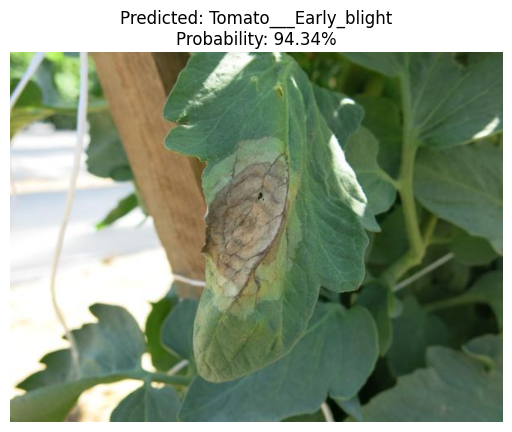

Prediction Time: 0.0184 seconds


In [17]:
import torch
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F
import time

def predict(image_path, model, device, transform, class_names):
    start_time = time.time()

    model.eval()
    image = Image.open(image_path).convert("RGB")
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        probabilities = F.softmax(output, dim=1)
        prob, pred = torch.max(probabilities, 1)

    class_name = class_names[pred.item()]
    probability = prob.item() * 100

    prediction_time = time.time() - start_time
    return image, class_name, probability, prediction_time

def show_prediction(image_path, model, device, transform, class_names):
    image, class_name, probability, prediction_time = predict(image_path, model, device, transform, class_names)

    plt.imshow(image)
    plt.axis('off')
    plt.title(f"Predicted: {class_name}\nProbability: {probability:.2f}%")
    plt.show()

    print(f"Prediction Time: {prediction_time:.4f} seconds")

image_path = "/content/sample.jpg"
show_prediction(image_path, model, device, transform_valid, train_data.classes)


## **Conclusion:**
This notebook demonstrates how to implement a deep learning-based plant disease classification system using ResNet50. By training on a dataset of plant leaves, the model can predict the species and the disease with high accuracy. The use of mixed precision, learning rate scheduling, and model optimization techniques ensures that the model can be trained efficiently.







